In [17]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [18]:
# Load the dataset
df = pd.read_csv("water_params_analysis_6.csv")
df

,Tanggal,P,Wf,Wl
0,01-11-2023,0.00,0.050000,0.500000
1,02-11-2023,0.00,0.050000,0.500000
2,03-11-2023,0.00,0.050000,0.500000
3,04-11-2023,0.00,0.050000,0.500000
4,05-11-2023,18.70,1.736681,0.699467
...,...,...,...,...
177,26-04-2024,10.65,1.263725,0.777333
178,27-04-2024,4.25,1.435640,0.800000
179,28-04-2024,0.00,0.447337,0.800000
180,29-04-2024,0.00,0.050000,0.779200


In [19]:
# Define input (antecedent) and output (consequent) variables
level = ctrl.Antecedent(np.arange(0, 151, 1), 'level')
flow = ctrl.Antecedent(np.arange(0, 372, 1), 'flow')
gate = ctrl.Consequent(np.arange(0, 101, 1), 'gate')

In [20]:
# Membership functions for 'level' using gaussmf
level['vlw'] = fuzz.gaussmf(level.universe, 2.9, 22.17)
level['lw'] = fuzz.gaussmf(level.universe, 56.1, 10.11)
level['med'] = fuzz.gaussmf(level.universe, 78.6, 13.08)
level['hg'] = fuzz.gaussmf(level.universe, 110.4, 16.65)
level['vhg'] = fuzz.gaussmf(level.universe, 148, 1.699)

In [21]:
# Membership functions for 'flow' using gaussmf
flow['vsl'] = fuzz.gaussmf(flow.universe, 0.565, 4.319)
flow['sl'] = fuzz.gaussmf(flow.universe, 13.62, 22.53)
flow['mid'] = fuzz.gaussmf(flow.universe, 72.4, 50.45)
flow['fs'] = fuzz.gaussmf(flow.universe, 197.1, 72.49)
flow['vfs'] = fuzz.gaussmf(flow.universe, 361.5, 7.461)

In [22]:
# Membership functions for 'gate' using gaussmf
gate['vnr'] = fuzz.gaussmf(gate.universe, 1.25, 9.555)
gate['nr'] = fuzz.gaussmf(gate.universe, 25, 10.62)
gate['avg'] = fuzz.gaussmf(gate.universe, 50, 10.62)
gate['wd'] = fuzz.gaussmf(gate.universe, 75, 10.62)
gate['vwd'] = fuzz.gaussmf(gate.universe, 101, 8.936)

c:\Applications\Anaconda3\envs\fuzzy_nfs\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


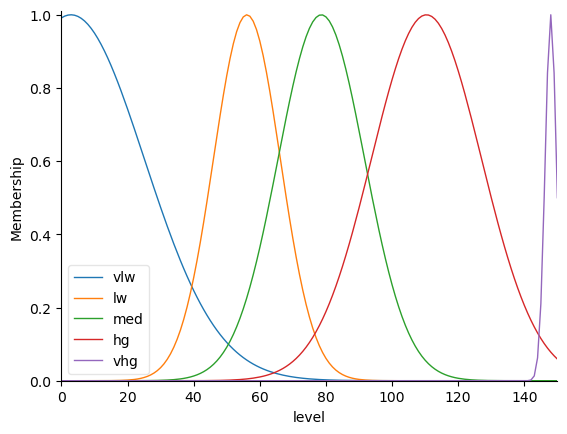

In [23]:
level.view()

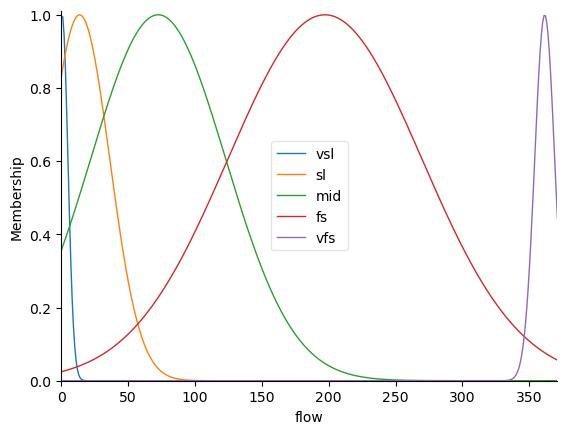

In [24]:
flow.view()

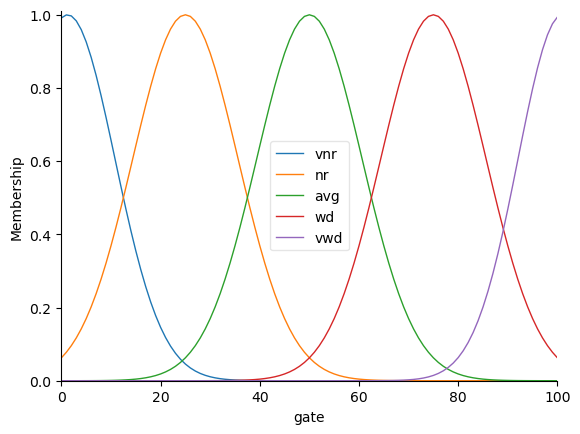

In [25]:
gate.view()

In [26]:
# Define the rule base
rules = [
    ctrl.Rule(level['vlw'] & flow['vsl'], gate['vnr']),
    ctrl.Rule(level['lw'] & flow['vsl'], gate['vnr']),
    ctrl.Rule(level['med'] & flow['vsl'], gate['vnr']),
    ctrl.Rule(level['hg'] & flow['vsl'], gate['nr']),
    ctrl.Rule(level['vhg'] & flow['vsl'], gate['avg']),

    ctrl.Rule(level['vlw'] & flow['sl'], gate['vnr']),
    ctrl.Rule(level['lw'] & flow['sl'], gate['vnr']),
    ctrl.Rule(level['med'] & flow['sl'], gate['nr']),
    ctrl.Rule(level['hg'] & flow['sl'], gate['avg']),
    ctrl.Rule(level['vhg'] & flow['sl'], gate['wd']),

    ctrl.Rule(level['vlw'] & flow['mid'], gate['vnr']),
    ctrl.Rule(level['lw'] & flow['mid'], gate['nr']),
    ctrl.Rule(level['med'] & flow['mid'], gate['avg']),
    ctrl.Rule(level['hg'] & flow['mid'], gate['wd']),
    ctrl.Rule(level['vhg'] & flow['mid'], gate['vwd']),

    ctrl.Rule(level['vlw'] & flow['fs'], gate['nr']),
    ctrl.Rule(level['lw'] & flow['fs'], gate['avg']),
    ctrl.Rule(level['med'] & flow['fs'], gate['wd']),
    ctrl.Rule(level['hg'] & flow['fs'], gate['vwd']),
    ctrl.Rule(level['vhg'] & flow['fs'], gate['vwd']),

    ctrl.Rule(level['vlw'] & flow['vfs'], gate['avg']),
    ctrl.Rule(level['lw'] & flow['vfs'], gate['wd']),
    ctrl.Rule(level['med'] & flow['vfs'], gate['vwd']),
    ctrl.Rule(level['hg'] & flow['vfs'], gate['vwd']),
    ctrl.Rule(level['vhg'] & flow['vfs'], gate['vwd'])
]

In [27]:
# Create control system and simulation
gate_ctrl = ctrl.ControlSystem(rules)
gate_sim = ctrl.ControlSystemSimulation(gate_ctrl)

In [28]:
# Compute gate for each row
gate_outputs = []
for i, row in df.iterrows():
    try:
        gate_sim.input['level'] = row['Wl'] * 100  # scale normalized Wl
        gate_sim.input['flow'] = row['Wf'] * 10  # scale normalized Wf
        gate_sim.compute()
        gate_outputs.append(gate_sim.output['gate'])
    except:
        gate_outputs.append(np.nan)


In [29]:
# Add to DataFrame
df['Gate'] = gate_outputs
df

,Tanggal,P,Wf,Wl,Gate
0,01-11-2023,0.00,0.050000,0.500000,24.612419
1,02-11-2023,0.00,0.050000,0.500000,24.612419
2,03-11-2023,0.00,0.050000,0.500000,24.612419
3,04-11-2023,0.00,0.050000,0.500000,24.612419
4,05-11-2023,18.70,1.736681,0.699467,35.979318
...,...,...,...,...,...
177,26-04-2024,10.65,1.263725,0.777333,39.346227
178,27-04-2024,4.25,1.435640,0.800000,40.571350
179,28-04-2024,0.00,0.447337,0.800000,36.076485
180,29-04-2024,0.00,0.050000,0.779200,33.253054


In [30]:
# Export to CSV
df.to_csv("skfuzzy4_mamdani_type1.2.csv", index=False)
print("skfuzzy4_mamdani_type1.2.csv")

skfuzzy4_mamdani_type1.2.csv


In [31]:
# For demonstration, set input values (optional)
level_input = 0.699467
flow_input = 1.736681

# Create a new simulation instance (recommended for reuse)
gate_sim = ctrl.ControlSystemSimulation(gate_ctrl)

gate_sim.input['level'] = level_input*100
gate_sim.input['flow'] = flow_input*10

In [32]:
# Compute the output
gate_sim.compute()
gate_sim.output['gate']

35.97933424146732